In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
file_path = "iot5_undersampled.csv"  # Ensure this file exists
df = pd.read_csv(file_path)

# Identify the target column
target_column = 'attack'  # Modify if needed

# Splitting features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Convert categorical variables to numerical
X = pd.get_dummies(X)

# Fill missing values
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(X.mean(), inplace=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define XGBoost model
xgb_clf = XGBClassifier(
    n_estimators=100,   # Number of trees
    max_depth=5,        # Depth of trees
    learning_rate=0.1,  # Step size
    subsample=0.8,      # Fraction of data to use per tree
    colsample_bytree=0.8, # Fraction of features per tree
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Train the model
xgb_clf.fit(X_train, y_train)

# Evaluate model
train_acc = accuracy_score(y_train, xgb_clf.predict(X_train))
test_acc = accuracy_score(y_test, xgb_clf.predict(X_test))
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Cross-Validation Score (mean): {cv_scores.mean():.4f}")


/home/mca/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:59:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mca/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mca/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:59:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mca/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:59:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mca/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:59:49] WARNING: /workspace/sr

Training Accuracy: 0.9999
Testing Accuracy: 0.9997
Cross-Validation Score (mean): 0.9997


In [7]:
import joblib

# Save the trained model
joblib.dump(xgb_clf, "xgmodel.pkl")  # Replace 'model' with your trained Random Forest model
print("✅ Model saved successfully as 'xgmodel.pkl'")

✅ Model saved successfully as 'xgmodel.pkl'


In [9]:
import joblib

# Save the feature names (column names after preprocessing)
joblib.dump(X.columns.tolist(), "xgfeatures.pkl")

# Identify categorical columns before one-hot encoding
categorical_columns = ['Flgs', 'Proto', 'SrcAddr', 'DstAddr', 'State']  # Modify based on your dataset

# Save the categorical column names
joblib.dump(categorical_columns, "xgca.pkl")

print("Features and categorical columns saved successfully!")


Features and categorical columns saved successfully!


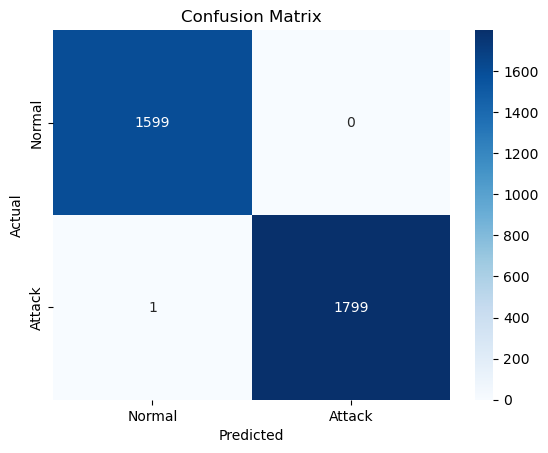

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1599
           1       1.00      1.00      1.00      1800

    accuracy                           1.00      3399
   macro avg       1.00      1.00      1.00      3399
weighted avg       1.00      1.00      1.00      3399

ROC-AUC Score: 1.0000
False Positive Rate (FPR): 0.0000
False Negative Rate (FNR): 0.0006


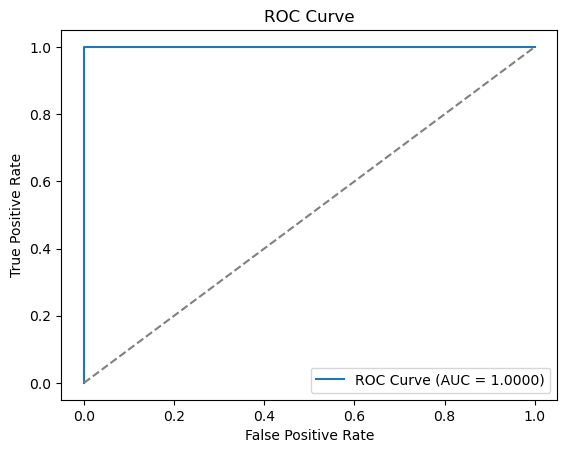

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = xgb_clf.predict(X_test)
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Extracting False Positive Rate (FPR) and False Negative Rate (FNR)
TN, FP, FN, TP = conf_matrix.ravel()
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate

print(f"False Positive Rate (FPR): {FPR:.4f}")
print(f"False Negative Rate (FNR): {FNR:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
